In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 
import tensorflow as tf
from keras.models import model_from_json
from skimage.transform import resize
from skimage import io

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    
    print('Load file {} ...'.format(filename))

    ds = pydicom.dcmread(filename) 
    img = ds.pixel_array
    print('img: ', img)
    print('img shape: ', img.shape)
    label = ds.StudyDescription
    sex = ds.PatientSex
    age = ds.PatientAge
    
    print(f'Patient: {sex},{age}')
    print('Findings: ', label)
    print('Modality/Type: ', ds.Modality)           # Type (should be DX for xray)
    print('Body Part Examined: ', ds.BodyPartExamined)   # Body Part (should be CHEST)
    print('Patient Position: ', ds.PatientPosition)    # Position (should be AP or PA)

    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.subplot(122)
    plt.hist(img.ravel(), bins=256)
    plt.suptitle(f'{label} - ({sex}, {age})')
    plt.show()
    
    # confirm the above variables meet our criteria 
    valid = True

    
    if ds.Modality != 'DX':
        print(f'Image not valid for model: Modality/Type is {ds.Modality}')
        valid = False
    
    if ds.BodyPartExamined != 'CHEST':
        print(f'Image not valid for model: Body Part Examined is {ds.BodyPartExamined}')
        valid = False
       
    if ds.PatientPosition not in ['AP', 'PA']:
        print(f'Image not valid for model: Patient Position is {ds.PatientPosition}')
        valid = False
  
    if valid:
        print(f'{filename}: Valid') 
        return img
    else:
        print(f'{filename}: Not Valid')        
        return None
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_size=(1,224,224,3)):
    img = img/255.0
    img_mean = np.mean(img)
    img_std = np.std(img)
    
    new_img = img.copy()
    new_img = (new_img - img_mean)/img_std
    new_img = resize(new_img, img_size)
    print(new_img.shape)
    return new_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    # load json and create model
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weight_path)
    print('Model Loaded: ', model_path)
    
    return loaded_model
    
# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    print('score: ', model.predict(img)[0][0])
    prediction = model.predict(img) > thresh
    return prediction[0][0]


Model Loaded:  ./model_512_7.json
Confirm file is valid for current model:
Acceptable Modality/Type: DX (Digital Radiography (X-ray))
Acceptable Body Part Examined: CHEST
Acceptable Patient Position: AP (anterior-posterior), PA (posterior-anterior) 

Load file test1.dcm ...
img:  [[199 175 152 ... 252 251 251]
 [150 128 114 ... 243 250 252]
 [122 110 102 ... 193 222 239]
 ...
 [ 44  47  51 ...  16  16  13]
 [ 44  48  52 ...  16  16  14]
 [ 45  48  53 ...  17  17  15]]
img shape:  (1024, 1024)
Patient: M,81
Findings:  No Finding
Modality/Type:  DX
Body Part Examined:  CHEST
Patient Position:  PA


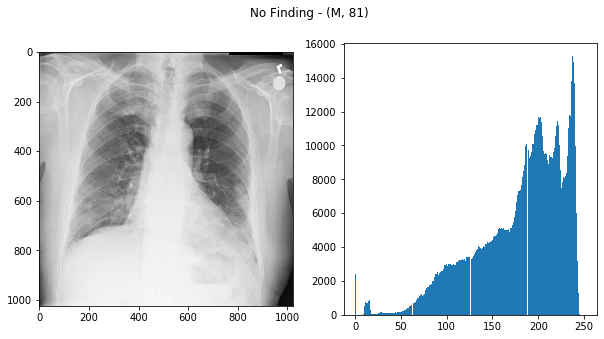

test1.dcm: Valid
(1, 224, 224, 3)
score:  0.9160202
Prediction:  True
Radiologist Findings:  No Finding

Load file test2.dcm ...
img:  [[202 199 195 ...   5   2   0]
 [199 196 195 ...   5   2   0]
 [196 194 193 ...   5   2   0]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 254 ...   0   0   0]
 [255 255 255 ...   0   0   0]]
img shape:  (1024, 1024)
Patient: M,58
Findings:  Cardiomegaly
Modality/Type:  DX
Body Part Examined:  CHEST
Patient Position:  AP


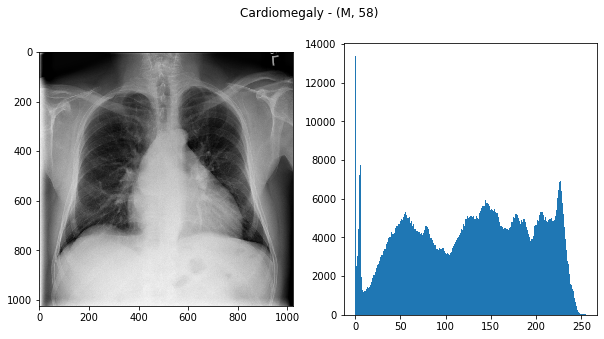

test2.dcm: Valid
(1, 224, 224, 3)
score:  0.8767551
Prediction:  True
Radiologist Findings:  Cardiomegaly

Load file test3.dcm ...
img:  [[142 142 143 ... 145 148  96]
 [138 136 138 ... 140 146  92]
 [133 134 132 ... 133 144  90]
 ...
 [  5   5   5 ...   4   3   0]
 [  5   5   5 ...   4   3   0]
 [  5   5   5 ...   4   3   0]]
img shape:  (1024, 1024)
Patient: M,77
Findings:  Effusion
Modality/Type:  DX
Body Part Examined:  CHEST
Patient Position:  AP


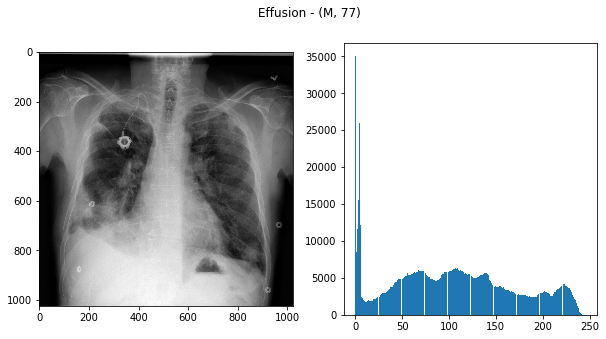

test3.dcm: Valid
(1, 224, 224, 3)
score:  0.9021353
Prediction:  True
Radiologist Findings:  Effusion

Load file test4.dcm ...
img:  [[199 175 152 ... 252 251 251]
 [150 128 114 ... 243 250 252]
 [122 110 102 ... 193 222 239]
 ...
 [ 44  47  51 ...  16  16  13]
 [ 44  48  52 ...  16  16  14]
 [ 45  48  53 ...  17  17  15]]
img shape:  (1024, 1024)
Patient: M,81
Findings:  No Finding
Modality/Type:  DX
Body Part Examined:  RIBCAGE
Patient Position:  PA


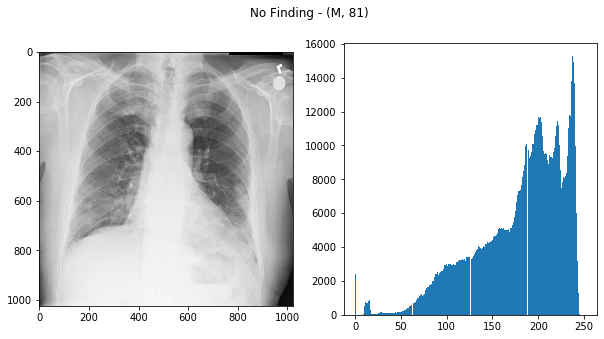

Image not valid for model: Body Part Examined is RIBCAGE
test4.dcm: Not Valid
Load file test5.dcm ...
img:  [[199 175 152 ... 252 251 251]
 [150 128 114 ... 243 250 252]
 [122 110 102 ... 193 222 239]
 ...
 [ 44  47  51 ...  16  16  13]
 [ 44  48  52 ...  16  16  14]
 [ 45  48  53 ...  17  17  15]]
img shape:  (1024, 1024)
Patient: M,81
Findings:  No Finding
Modality/Type:  CT
Body Part Examined:  CHEST
Patient Position:  PA


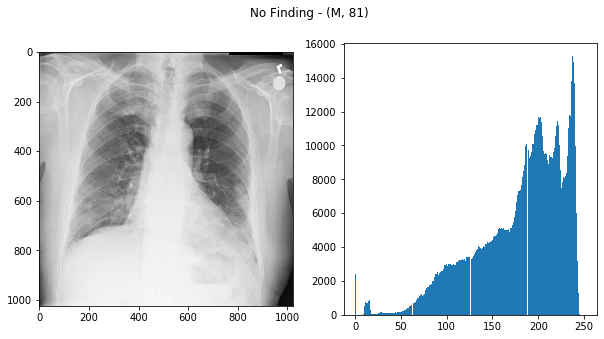

Image not valid for model: Modality/Type is CT
test5.dcm: Not Valid
Load file test6.dcm ...
img:  [[199 175 152 ... 252 251 251]
 [150 128 114 ... 243 250 252]
 [122 110 102 ... 193 222 239]
 ...
 [ 44  47  51 ...  16  16  13]
 [ 44  48  52 ...  16  16  14]
 [ 45  48  53 ...  17  17  15]]
img shape:  (1024, 1024)
Patient: M,81
Findings:  No Finding
Modality/Type:  DX
Body Part Examined:  CHEST
Patient Position:  XX


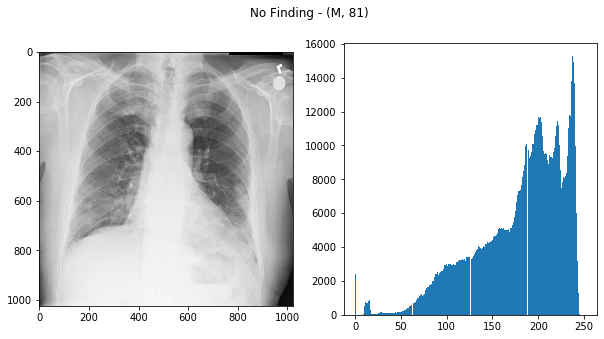

Image not valid for model: Patient Position is XX
test6.dcm: Not Valid


In [4]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = './model_512_7.json'        
weight_path = './xray_class_7_my_model.best.hdf5'

IMG_SIZE=(1,224,224,3)# This might be different if you did not use vgg16

my_model = load_model(model_path, weight_path)
thresh = 0.23956428 #loads the threshold for model classification 

# use the .dcm files to test prediction
print('Confirm file is valid for current model:')
print('Acceptable Modality/Type: DX (Digital Radiography (X-ray))')
print('Acceptable Body Part Examined: CHEST')
print('Acceptable Patient Position: AP (anterior-posterior), PA (posterior-anterior) \n')

for i in test_dicoms:
    
    # check dicom to ensure file conforms to model requirements
    img = check_dicom(i)
    
    if img is None:
        continue
        
    # pre-process image
    img_proc = preprocess_image(img,IMG_SIZE)
    # get prediction
    pred = predict_image(my_model,img_proc,thresh)
    print('Prediction: ', pred)
    print('Radiologist Findings: ', pydicom.dcmread(i).StudyDescription)
    print('========================================================================\n')
